# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  zx2201
* Name: Zhifu Xiao

### Team Member 2 :
* UNI:  kl2912
* Name: Kunyi Liu

You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [1]:
# import libraries
% matplotlib inline
import numpy as np
import pandas as pd
import io
import math
import string
import statistics
import re
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import scale, StandardScaler
import itertools
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
#    print(important)
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

In [4]:
def plot_important_features_km(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    high = inds[-top_n:]
    important = np.hstack([high])
#    print(important)
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

In [5]:
def print_topics(topics, feature_names, components, topics_per_chunk=1,
                 n_words=10):
    sorting = components
    #np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")


In [7]:
# Add your code for task 1 here. You may use multiple cells. 
data = pd.read_csv('Vision_Zero_Entry.csv')
data = data[['REQUESTTYPE', 'COMMENTS']]

In [8]:
for i in range(0,data.REQUESTTYPE.shape[0]):
        if ';' in data.REQUESTTYPE[i]:
            data.REQUESTTYPE[i] = data.REQUESTTYPE[i].split(';')[1]
        if "bike facilities" in data.REQUESTTYPE[i]:
            data.REQUESTTYPE[i] = "Bike facilities"
#        if "yield" in data.REQUESTTYPE[i]:  
#            data.REQUESTTYPE[i] = "Don't yield"
        if "see" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Low visibility"       
        if "wait" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Wait too long"
        if "sidewalks" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Sidewalks"
        if "surface" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Roadway surface"       
#        if "time" in data.REQUESTTYPE[i] or "far" in data.REQUESTTYPE[i]:  
#            data.REQUESTTYPE[i] = "Too far"
        if "time" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Not enough time"
        if "far" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Too far"
        if "something" in data.REQUESTTYPE[i]:  
            data.REQUESTTYPE[i] = "Others"
        if data.COMMENTS[i] is np.NaN:
            data.REQUESTTYPE[i] = np.NaN

In [9]:
newdata = data.drop_duplicates()
newdata = newdata.dropna()

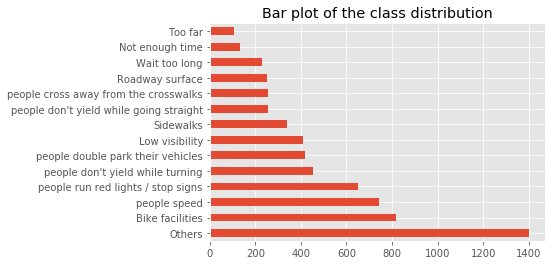

In [10]:
agg = newdata['REQUESTTYPE'].value_counts()
agg.plot(kind='barh', title='Bar plot of the class distribution');

In [11]:
X_train = newdata['COMMENTS']
y_train = newdata['REQUESTTYPE']
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, random_state=0)

In this step, we merged several similiar categories together and drop all observations with missing comments and duplicate comments. The class distribution is shown above. From the plot we could find that Others occurs mostly with around 1400 observation. Bike facilities occurs second, with around 800 observations. Too far and enough time occurs less freqently, with around 100 observations.

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [12]:
my_stopwords = set(ENGLISH_STOP_WORDS)
my_stopwords.remove("too")
my_stopwords.add("even")

In [13]:
vect = CountVectorizer(min_df=3, ngram_range=(1,2), token_pattern=r"\b\w[\w’]+\b", stop_words=my_stopwords)
X_train_bag = vect.fit_transform(X_train)
X_val_bag = vect.transform(X_val)
lr = LogisticRegressionCV().fit(X_train_bag, y_train)
y_val_pred = lr.predict(X_val_bag)

In [16]:
print(adjusted_rand_score(y_val_pred,y_val))
#assert np.mean(cross_val_score(lr, X_train_bag, y_train, cv = 5, scoring = 'f1_macro'))>0.5
print(f1_score(y_val, y_val_pred, average='macro'))
assert f1_score(y_val, y_val_pred, average='macro')>0.5

0.265992708366
0.506493732063


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


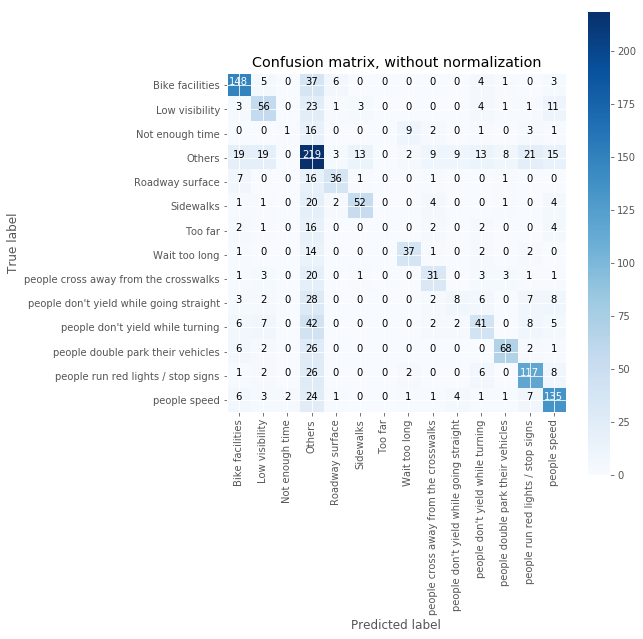

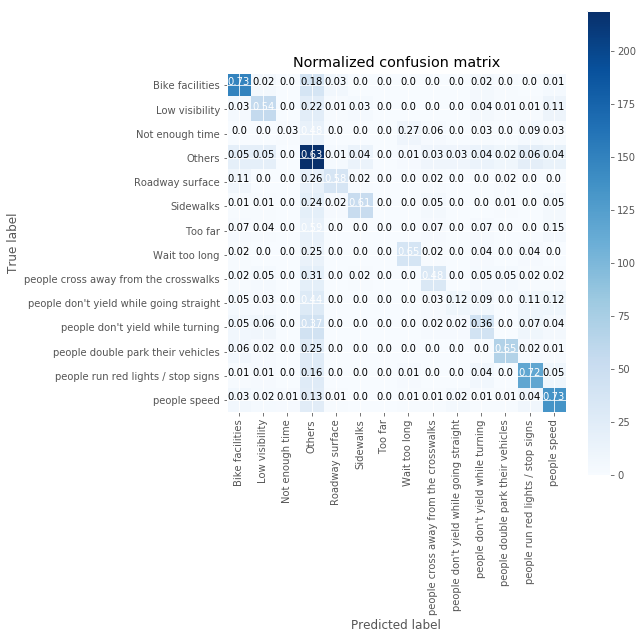

In [15]:
cnf_matrix = confusion_matrix(y_val, y_val_pred)
np.set_printoptions(precision=2)
cnf_class = lr.classes_
# Plot non-normalized confusion matrix
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, classes=cnf_class,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, classes=cnf_class, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

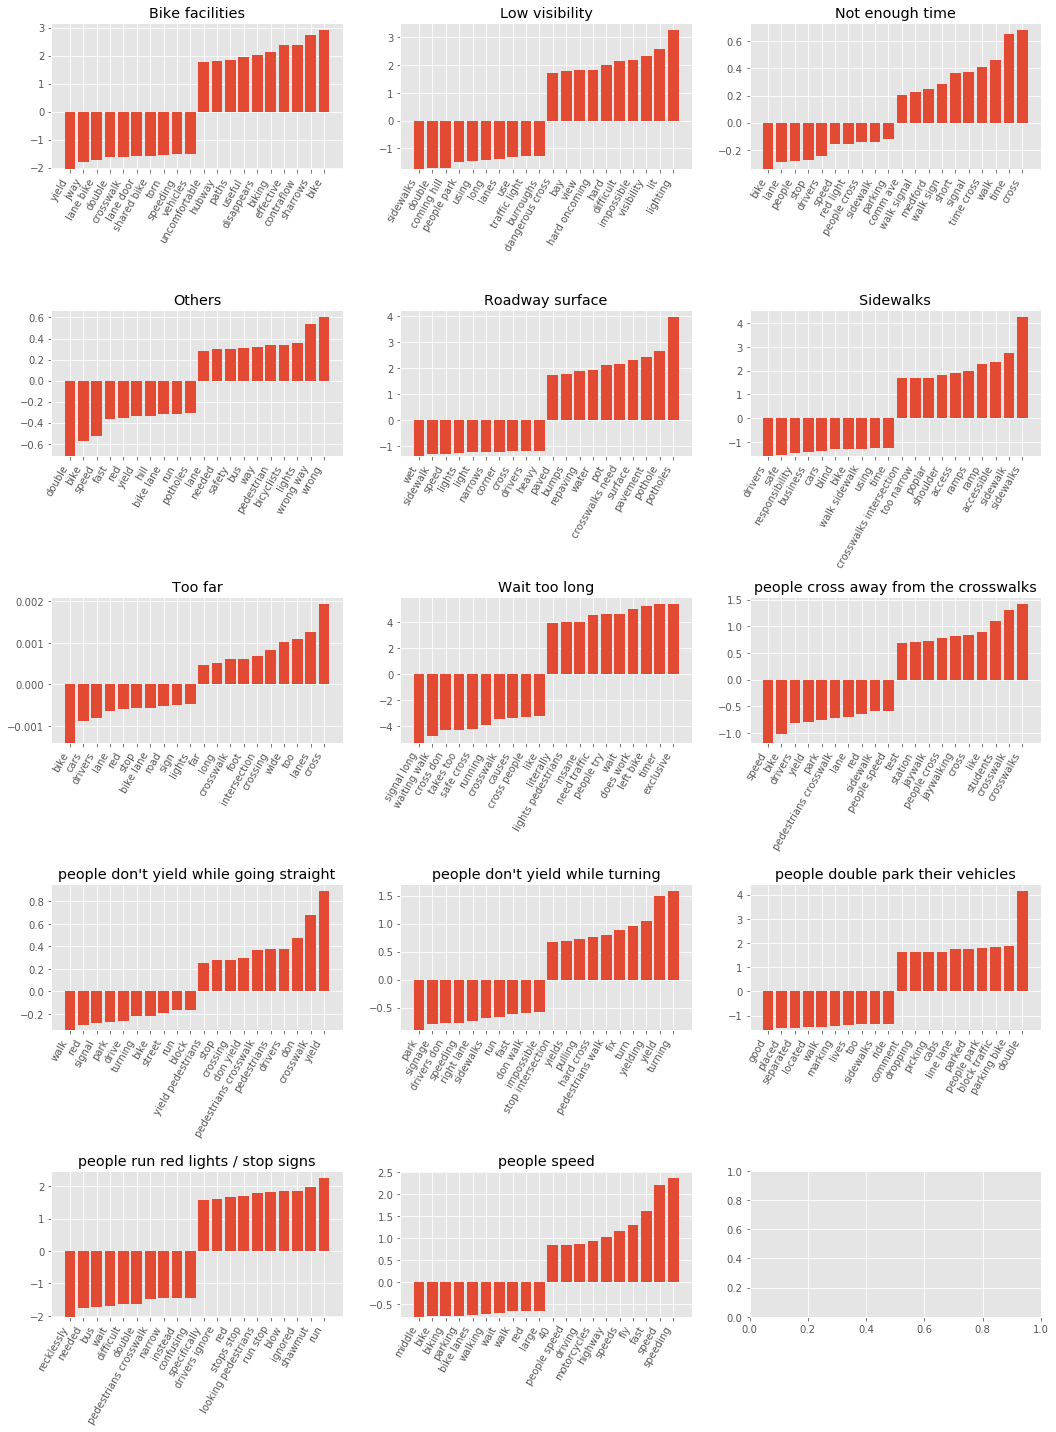

In [17]:
feature_names = np.array(vect.get_feature_names())
n_classes = len(lr.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 20))
for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
    ax.set_title(label)
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
plt.tight_layout()

In [18]:
y_val_df = pd.Series(y_val_pred)
y_val_df.index = y_val.index
y_val_df = pd.DataFrame(y_val_df[y_val != y_val_df])
y_val_df.columns = ['Predicted Label']

In [19]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_pred]),pd.DataFrame(y_val[y_val != y_val_pred]), y_val_df], axis=1)

,COMMENTS,REQUESTTYPE,Predicted Label
7163,Unless the street is clogged with traffic.,people speed,Others
203,Stop sign and street sign missing,people don't yield while turning,Others
8292,Light cycle at Hanover can back up traffic to ...,people run red lights / stop signs,Wait too long
7699,I have almost been hit by a car twice on this ...,people speed,Others
8450,Very dangerous for all cars (will be 60+ cars ...,Low visibility,Others
4188,There should be a dedicated drop-off spot for ...,people double park their vehicles,Others
3559,Young & healthy & I have to walk diagonally to...,Not enough time,Others
8474,There aren't enough places to cross the street.,Too far,Others
4802,The cars from North St. Constantly block this ...,people run red lights / stop signs,Others
1799,"Drives ""block the box"" - block the intersectio...",Others,people run red lights / stop signs


In [24]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_pred]),pd.DataFrame(y_val[y_val != y_val_pred]), y_val_df], axis=1).iloc[2].COMMENTS

'Light cycle at Hanover can back up traffic to this point, leaving cars in the intersection when the (short) walk signal comes on. Peds have to cross between cars-meanwhile Hanover light is green and cars begin to move.'

In [21]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_pred]),pd.DataFrame(y_val[y_val != y_val_pred]), y_val_df], axis=1).iloc[2]

COMMENTS           Light cycle at Hanover can back up traffic to ...
REQUESTTYPE                       people run red lights / stop signs
Predicted Label                                        Wait too long
Name: 8292, dtype: object

In [22]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_pred]),pd.DataFrame(y_val[y_val != y_val_pred]), y_val_df], axis=1).iloc[3].COMMENTS

"I have almost been hit by a car twice on this road! Cars come flying and don't see what's around the corner"

In [23]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_pred]),pd.DataFrame(y_val[y_val != y_val_pred]), y_val_df], axis=1).iloc[3]

COMMENTS           I have almost been hit by a car twice on this ...
REQUESTTYPE                                             people speed
Predicted Label                                               Others
Name: 7699, dtype: object

In this step, we use the basic model with CountVectorizer and LogisticRegression, and the f1 macro score is just above 0.5. From the confusion matrix we could see that the category Others have the most mispredicted observations, and There are some categories that are not predicted properly. From the feature plot, we could see that most of them are quite meaningful, but the Others has vague features, which is understandable. There are two examples of misprediction, one is that the comment is very long and with many informations. As a result, the algorithm may choose one category over the other. The second example is that a comment describing people speed is mispredicted to Others. Perhaps there are some words that is viewed to be suitable to the Others category.

# Task3 - Model 2 [30 points]


Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.01],
              "countvectorizer__ngram_range": [(1, 2), (1, 3), (1, 4)],
              "countvectorizer__min_df": [2, 3, 4],
              "countvectorizer__stop_words": [None, my_stopwords],
              "normalizer": [None, Normalizer()]
             }
grid = GridSearchCV(make_pipeline(CountVectorizer(token_pattern = r"\b\w[\w’]+\b"), Normalizer(), LogisticRegression()),
                    param_grid=param_grid, cv=5, scoring="f1_macro", verbose = 1)

In [26]:
grid.fit(X_train, y_train)
y_val_best_prd = grid.best_estimator_.predict(X_val)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int

In [28]:
print(f1_score(y_val, y_val_best_prd, average="macro"))
print(adjusted_rand_score(y_val, y_val_best_prd))

0.54261476136
0.280911560453


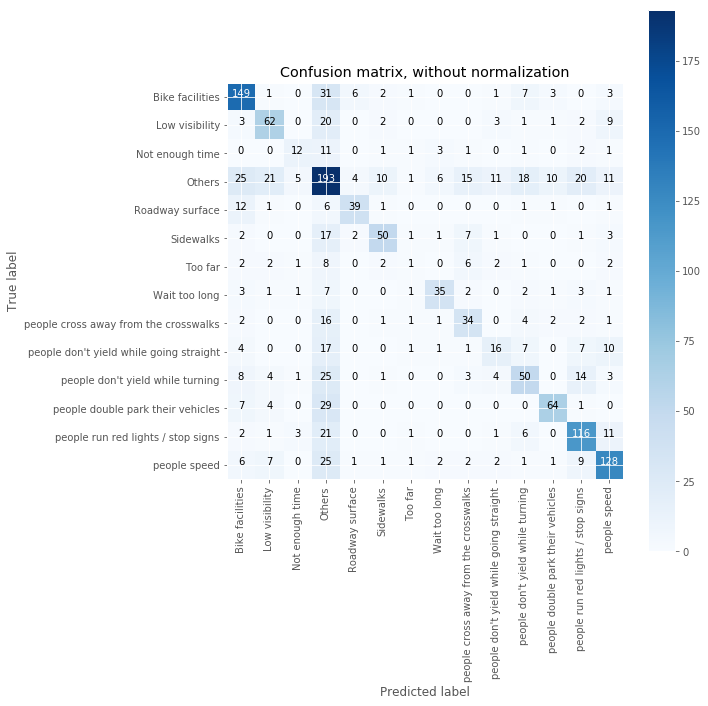

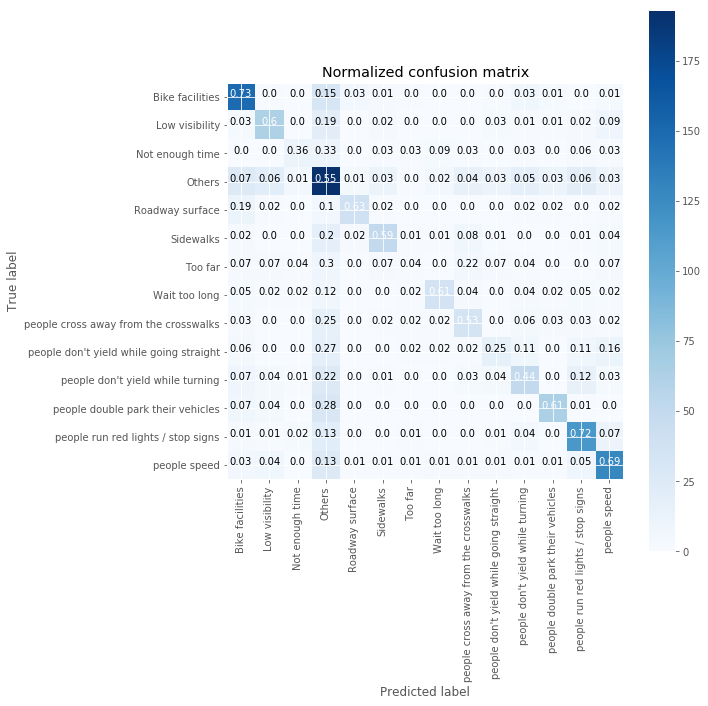

In [29]:
cnf_matrix = confusion_matrix(y_val, y_val_best_prd)
np.set_printoptions(precision=2)
cnf_class = grid.best_estimator_.named_steps['logisticregression'].classes_
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=cnf_class,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=cnf_class, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

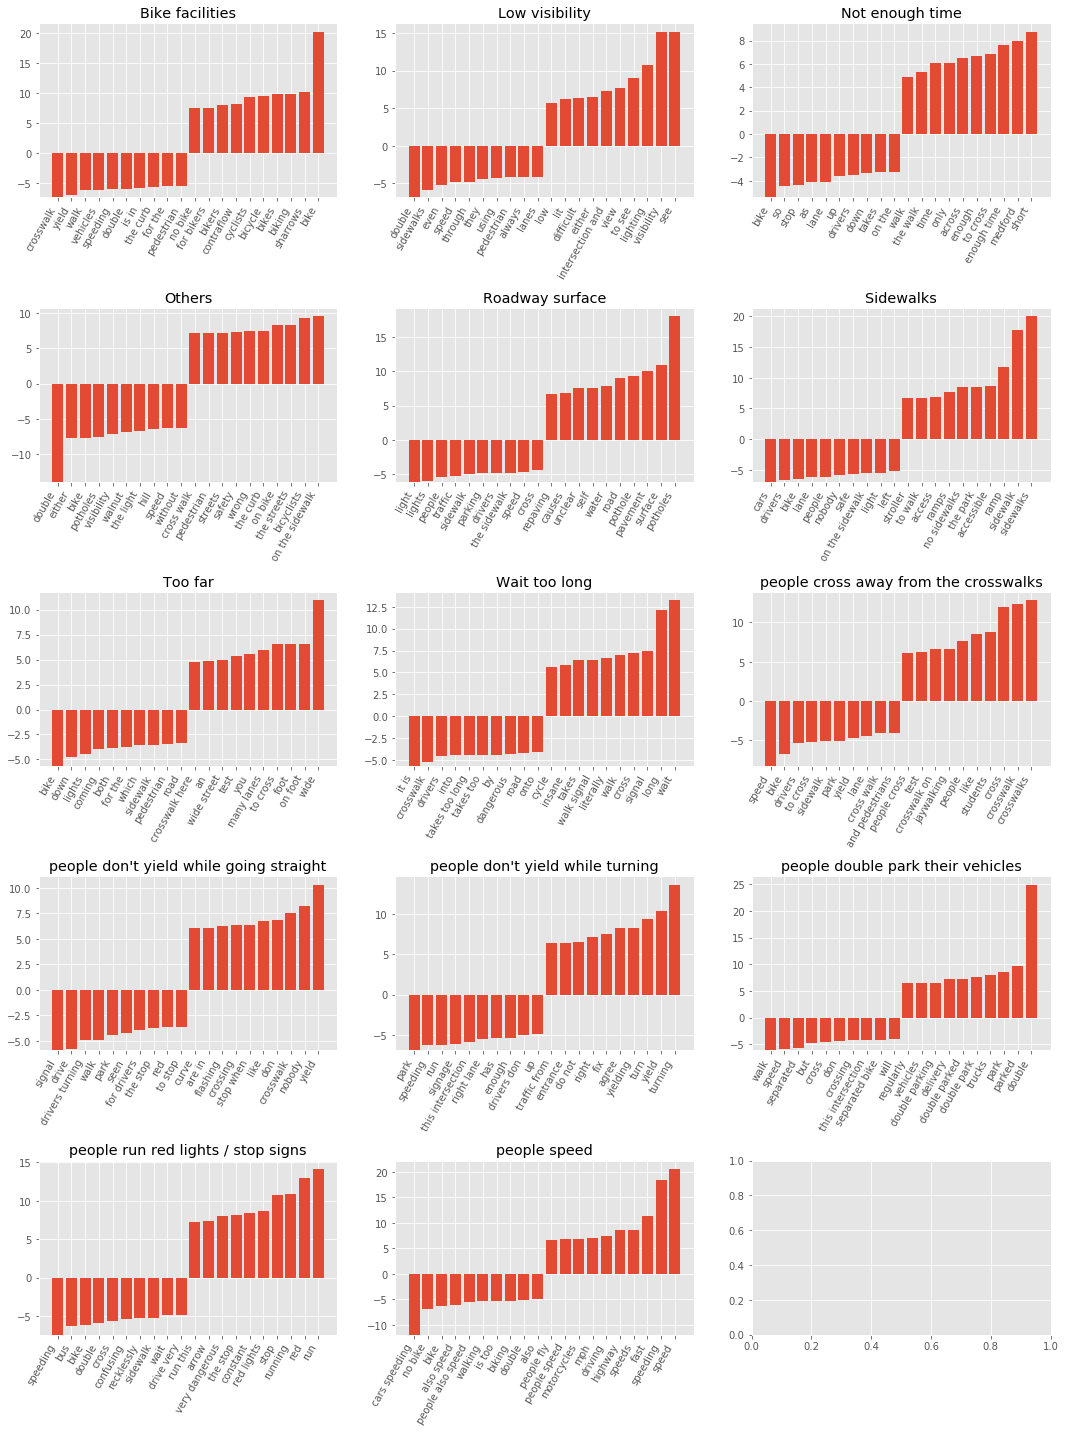

In [31]:
feature_names = np.array(grid.best_estimator_.named_steps['countvectorizer'].get_feature_names())
n_classes = len(grid.best_estimator_.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 20))
for ax, coef, label in zip(axes.ravel(), grid.best_estimator_.named_steps['logisticregression'].coef_, grid.best_estimator_.named_steps['logisticregression'].classes_):
    ax.set_title(label)
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [47]:
y_val_best_pred = grid.best_estimator_.predict(X_val)
y_val_best_df = pd.Series(y_val_best_pred)
y_val_best_df.index = y_val.index
y_val_best_df = pd.DataFrame(y_val_best_df[y_val != y_val_best_df])
y_val_best_df.columns = ['Predicted Label']

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [48]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_best_pred]),pd.DataFrame(y_val[y_val != y_val_best_pred]), y_val_best_df], axis=1)

,COMMENTS,REQUESTTYPE,Predicted Label
4511,Morton St. needs barrier-protected commuter bi...,Bike facilities,Others
3820,Poor to non existent lighting between the Arth...,Low visibility,Others
203,Stop sign and street sign missing,people don't yield while turning,people run red lights / stop signs
6448,Since this intersection allows for pedestrians...,Others,Wait too long
8292,Light cycle at Hanover can back up traffic to ...,people run red lights / stop signs,Not enough time
7699,I have almost been hit by a car twice on this ...,people speed,Low visibility
8450,Very dangerous for all cars (will be 60+ cars ...,Low visibility,Others
4188,There should be a dedicated drop-off spot for ...,people double park their vehicles,Others
8474,There aren't enough places to cross the street.,Too far,Not enough time
4802,The cars from North St. Constantly block this ...,people run red lights / stop signs,Others


In [50]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_best_pred]),pd.DataFrame(y_val[y_val != y_val_best_pred]), y_val_best_df], axis=1)

,COMMENTS,REQUESTTYPE,Predicted Label
4511,Morton St. needs barrier-protected commuter bi...,Bike facilities,Others
3820,Poor to non existent lighting between the Arth...,Low visibility,Others
203,Stop sign and street sign missing,people don't yield while turning,people run red lights / stop signs
6448,Since this intersection allows for pedestrians...,Others,Wait too long
8292,Light cycle at Hanover can back up traffic to ...,people run red lights / stop signs,Not enough time
7699,I have almost been hit by a car twice on this ...,people speed,Low visibility
8450,Very dangerous for all cars (will be 60+ cars ...,Low visibility,Others
4188,There should be a dedicated drop-off spot for ...,people double park their vehicles,Others
8474,There aren't enough places to cross the street.,Too far,Not enough time
4802,The cars from North St. Constantly block this ...,people run red lights / stop signs,Others


In [53]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_best_pred]),pd.DataFrame(y_val[y_val != y_val_best_pred]), y_val_best_df], axis=1).iloc[1]

COMMENTS           Poor to non existent lighting between the Arth...
REQUESTTYPE                                           Low visibility
Predicted Label                                               Others
Name: 3820, dtype: object

In [54]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_best_pred]),pd.DataFrame(y_val[y_val != y_val_best_pred]), y_val_best_df], axis=1).iloc[1].COMMENTS

'Poor to non existent lighting between the Arthur Fiedler Footbridge and the residences at 91 Beacon makes this area dangerous at night.  During summer months transients use this area to congregate and carouse.  Please add lighting and blue call box'

In [55]:
pd.concat([pd.DataFrame(X_val[y_val != y_val_best_pred]),pd.DataFrame(y_val[y_val != y_val_best_pred]), y_val_best_df], axis=1).iloc[2]

COMMENTS            Stop sign and street sign missing
REQUESTTYPE          people don't yield while turning
Predicted Label    people run red lights / stop signs
Name: 203, dtype: object

In task 3, we used GridSearchCV to search among some possible hyperparameters. The best estimator from GridSearchCv turns out to be slightly better than the original model. From the confusion matrix plot and feature plot, we could see that there are some improvements on both, and the important features is even more meaningful, as there are less stop words here. There are two examples showing some prediction mistakes. The first one is that the low visibility is predicted to be others, while the second one is that people don't yield while turning is predicted to be people run red lights / stop signs. The second one is actually make sense since it clearly points to stop sign.

# Task4 - Visualize Results [10 points]

Task4 is completed in the previous part.

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.


In [56]:
X_train_all = newdata['COMMENTS']
y_train_all = newdata['REQUESTTYPE']
my_stopwords.add("st")
my_stopwords.add("ave")

## KMeans

In [57]:
vect = CountVectorizer(min_df=3, ngram_range=(1,2), token_pattern=r"\b\w[\w’]+\b", stop_words=my_stopwords)
X_train_all_bag = vect.fit_transform(X_train_all)

In [58]:
km = KMeans(n_clusters=13)
X_kmeans = km.fit_transform(X_train_all_bag)
adjusted_rand_score(km.labels_,y_train_all)

0.050598370326630698

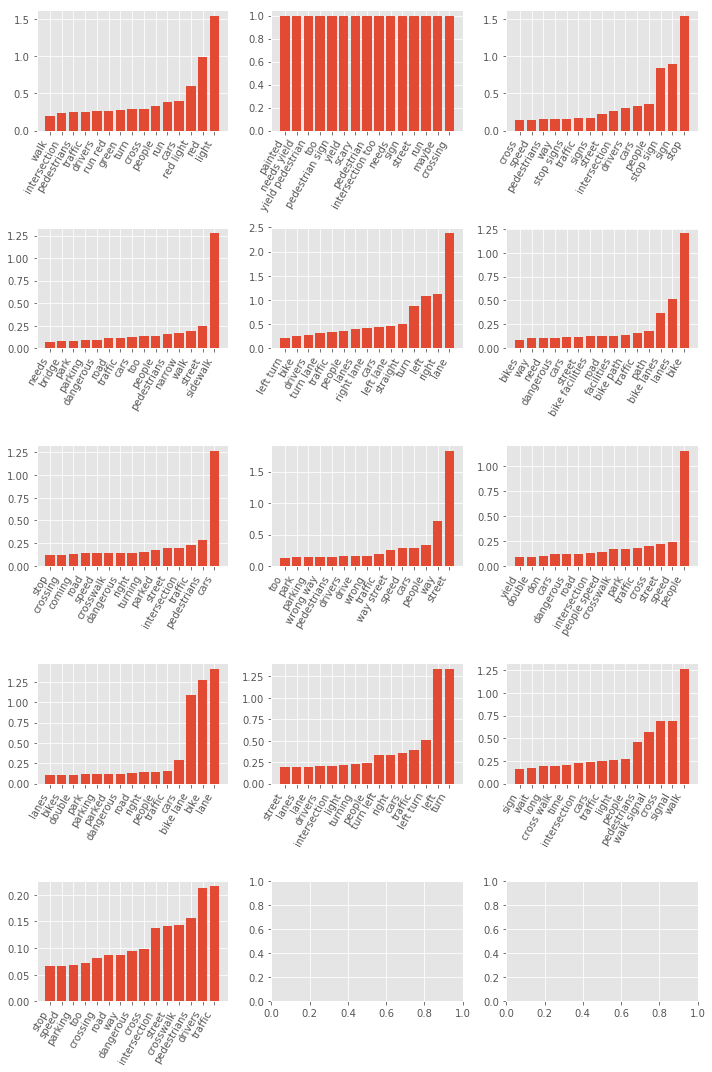

In [59]:
feature_names = np.array(vect.get_feature_names())
n_components = 13
fig, axes = plt.subplots(n_components // 3+1, 3, figsize=(10, 15))
for ax, coef in zip(axes.ravel(), km.cluster_centers_):
    plot_important_features_km(coef, feature_names, top_n=15, ax=ax)
plt.tight_layout()

From KMeans, we could see that more than half of the labels is meaningful. For example, the first cluster with light, red, etc., clear means that it is some problem with cars that are not act correctly during red light. There are some, however, is not very clear, like the second cluster. Overall, KMeans is a good way to process clustering and it is the most easy one to understand. The ARI is relatively low.

## TruncatedSVD

In [60]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=13)
X_lsa = lsa.fit_transform(X_train_all_bag)

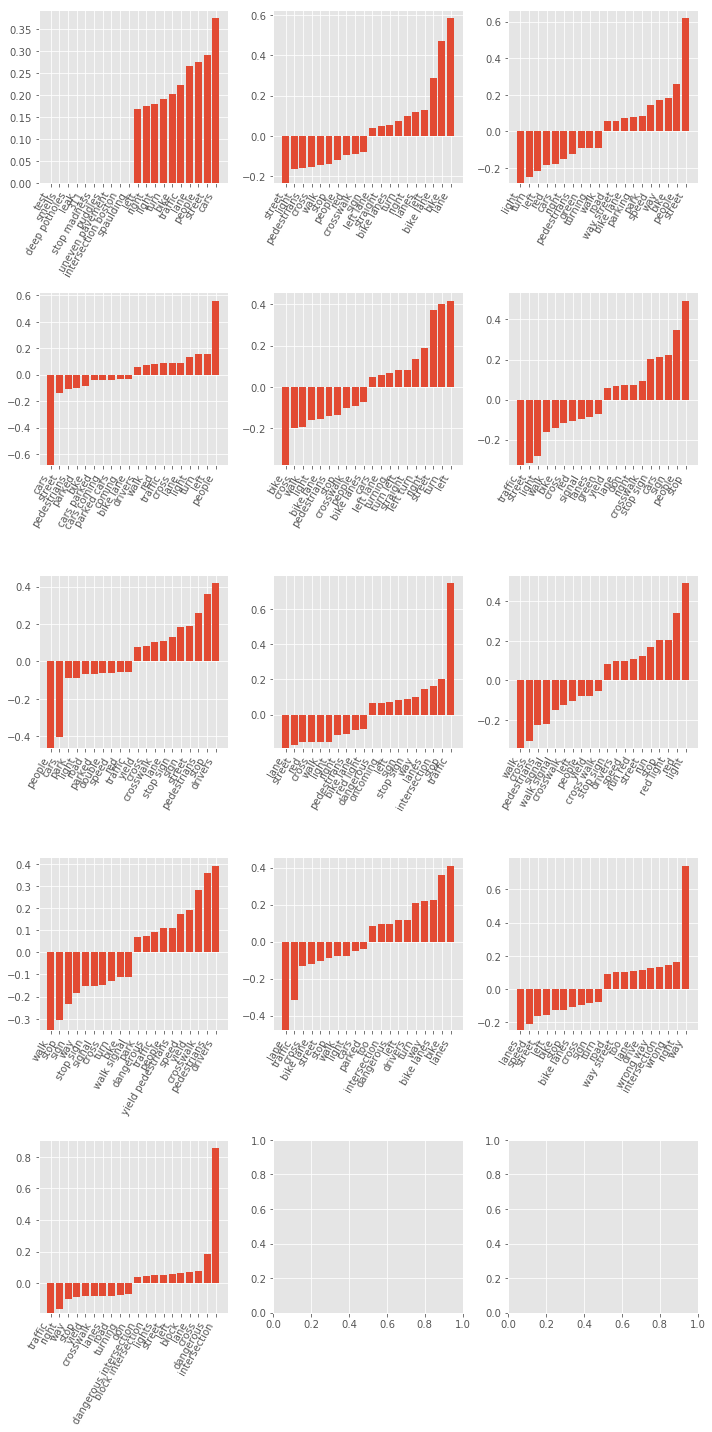

In [62]:
feature_names = np.array(vect.get_feature_names())
n_components = 13
fig, axes = plt.subplots(n_components // 3+1, 3, figsize=(10, 20))
for ax, coef in zip(axes.ravel(), lsa.components_):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
plt.tight_layout()

In [63]:
from sklearn.preprocessing import MaxAbsScaler, Normalizer
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train_all_bag)
X_normalized = Normalizer().fit_transform(X_train_all_bag)

lsa_normalized = TruncatedSVD(n_components=13)
X_lsa_normalized = lsa_normalized.fit_transform(X_normalized)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [64]:
km1 = KMeans(n_clusters=17, init='k-means++', max_iter=100)
km1.fit(X_lsa_normalized)
adjusted_rand_score(km1.labels_,y_train_all)

0.060130746215910226

In [65]:
y_train_all_svd = km1.labels_
X_train_svd, X_val_svd, y_train_svd, y_val_svd = train_test_split(
    X_train_all_bag, y_train_all_svd, stratify=y_train_all_svd, random_state=0)
lr_svd = LogisticRegressionCV().fit(X_train_svd, y_train_svd)
y_val_svd_pred = lr_svd.predict(X_val_svd)
f1_score(y_val_svd, y_val_svd_pred, average='macro')
assert f1_score(y_val_svd, y_val_svd_pred, average='macro')>0.8

0.8386479931204297

The results from TruncatedSVD could be understanded easily: the second cluster represents some problems with bike and bike line, while the fifth cluster represents turning problem. However, some clusters are relatively vague compared to the others, and it might be hard to interpret. The ARI is 0.06, which is not very high, but the f1 score is high, with around 0.83.

## NMF

In [83]:
from sklearn.decomposition import NMF
nmf_scale = NMF(n_components=11, verbose=10, tol=0.01)
nmf_scale.fit(X_scaled)
X_nmf_scale = nmf_scale.transform(X_scaled)
labels = X_nmf_scale.argmax(axis=1)
adjusted_rand_score(labels,y_train_all)

violation: 1.0
violation: 0.44600507094845177
violation: 0.28465374549217176
violation: 0.17980001009801203
violation: 0.11992576932055245
violation: 0.0825183176922589
violation: 0.060358053303307166
violation: 0.0472943797316726
violation: 0.03888446931020773
violation: 0.03266023692527955
violation: 0.027611093287013094
violation: 0.023479359896419406
violation: 0.02011825651388918
violation: 0.017273441929279747
violation: 0.014865824767284447
violation: 0.012851043315619235
violation: 0.011133562889101412
violation: 0.009682441317044457
Converged at iteration 18
violation: 1.0
violation: 0.2769520084515827
violation: 0.011324826095303652
violation: 0.0013847296894867892
Converged at iteration 4


0.13711401319457114

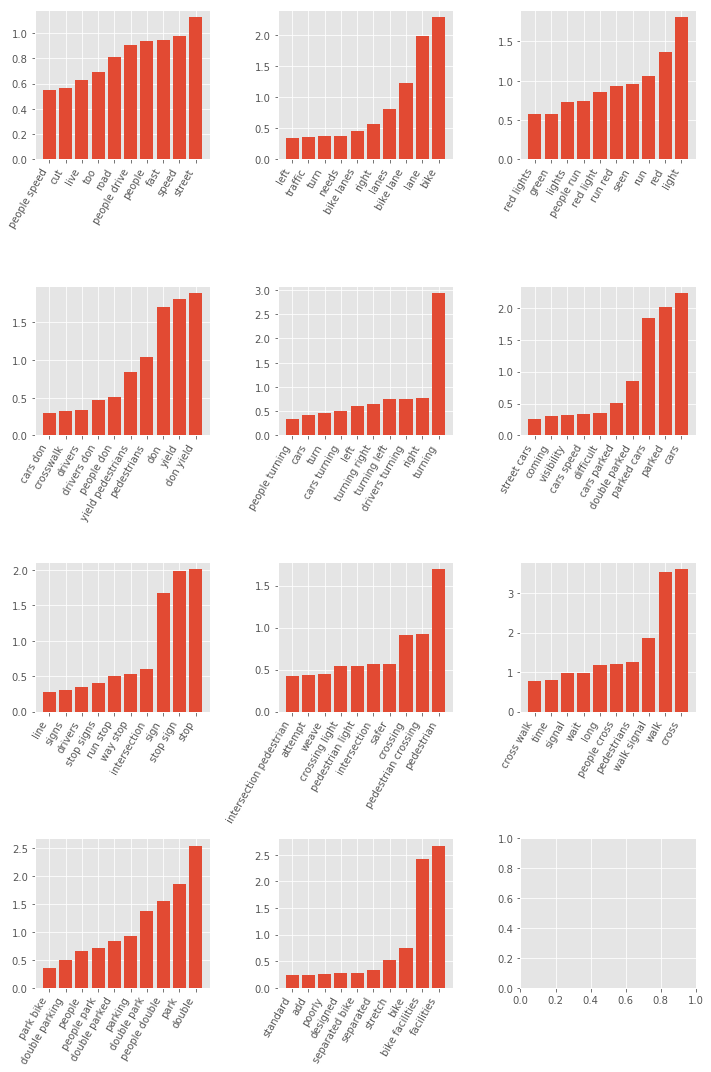

In [68]:
large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[:][::-1]
feature_names = np.array(vect.get_feature_names())
n_components = 11
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 15))
for ax, coef in zip(axes.ravel(), nmf_scale.components_[large_comp_inds, :]):
    plot_important_features_km(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [69]:
sorting = np.argsort(nmf_scale.components_, axis=1)[:, ::-1]
print_topics(large_comp_inds, feature_names, sorting, topics_per_chunk=5)

topic 6       topic 1       topic 9       topic 2       topic 4       
--------      --------      --------      --------      --------      
street        bike          light         don yield     turning       
speed         lane          red           yield         right         
fast          bike lane     run           don           drivers turning
people        lanes         seen          pedestrians   turning left  
people drive  right         run red       yield pedestriansturning right 
road          bike lanes    red light     people don    left          
too           needs         people run    drivers don   cars turning  
live          turn          lights        drivers       turn          
cut           traffic       green         crosswalk     cars          
people speed  left          red lights    cars don      people turning


topic 5       topic 3       topic 8       topic 0       topic 7       
--------      --------      --------      --------      --------      


In [70]:
y_train_all_nmf = X_nmf_scale.argmax(axis=1)
X_train_nmf, X_val_nmf, y_train_nmf, y_val_nmf = train_test_split(
    X_train_all_bag, y_train_all_nmf, stratify=y_train_all_nmf, random_state=0)
lr_nmf = LogisticRegressionCV().fit(X_train_nmf, y_train_nmf)
y_val_nmf_pred = lr_nmf.predict(X_val_nmf)
f1_score(y_val_nmf, y_val_nmf_pred, average='macro')
assert f1_score(y_val_nmf, y_val_nmf_pred, average='macro') > 0.85

0.86485357324355572

The NMF model is so far the best clustering model in this case. The ARI is relatively high with around 0.12, and the topic words in each cluster is very clear. For example, topic 10 clearly means bike facilities, while topic 7 clearly means double parking issues. The f1 score is also very high with around 0.86.

## LDA

In [71]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch")
X_lda = lda.fit_transform(X_train_all_bag)
labels = X_lda.argmax(axis=1)
adjusted_rand_score(labels,y_train_all)

0.061423951587912688

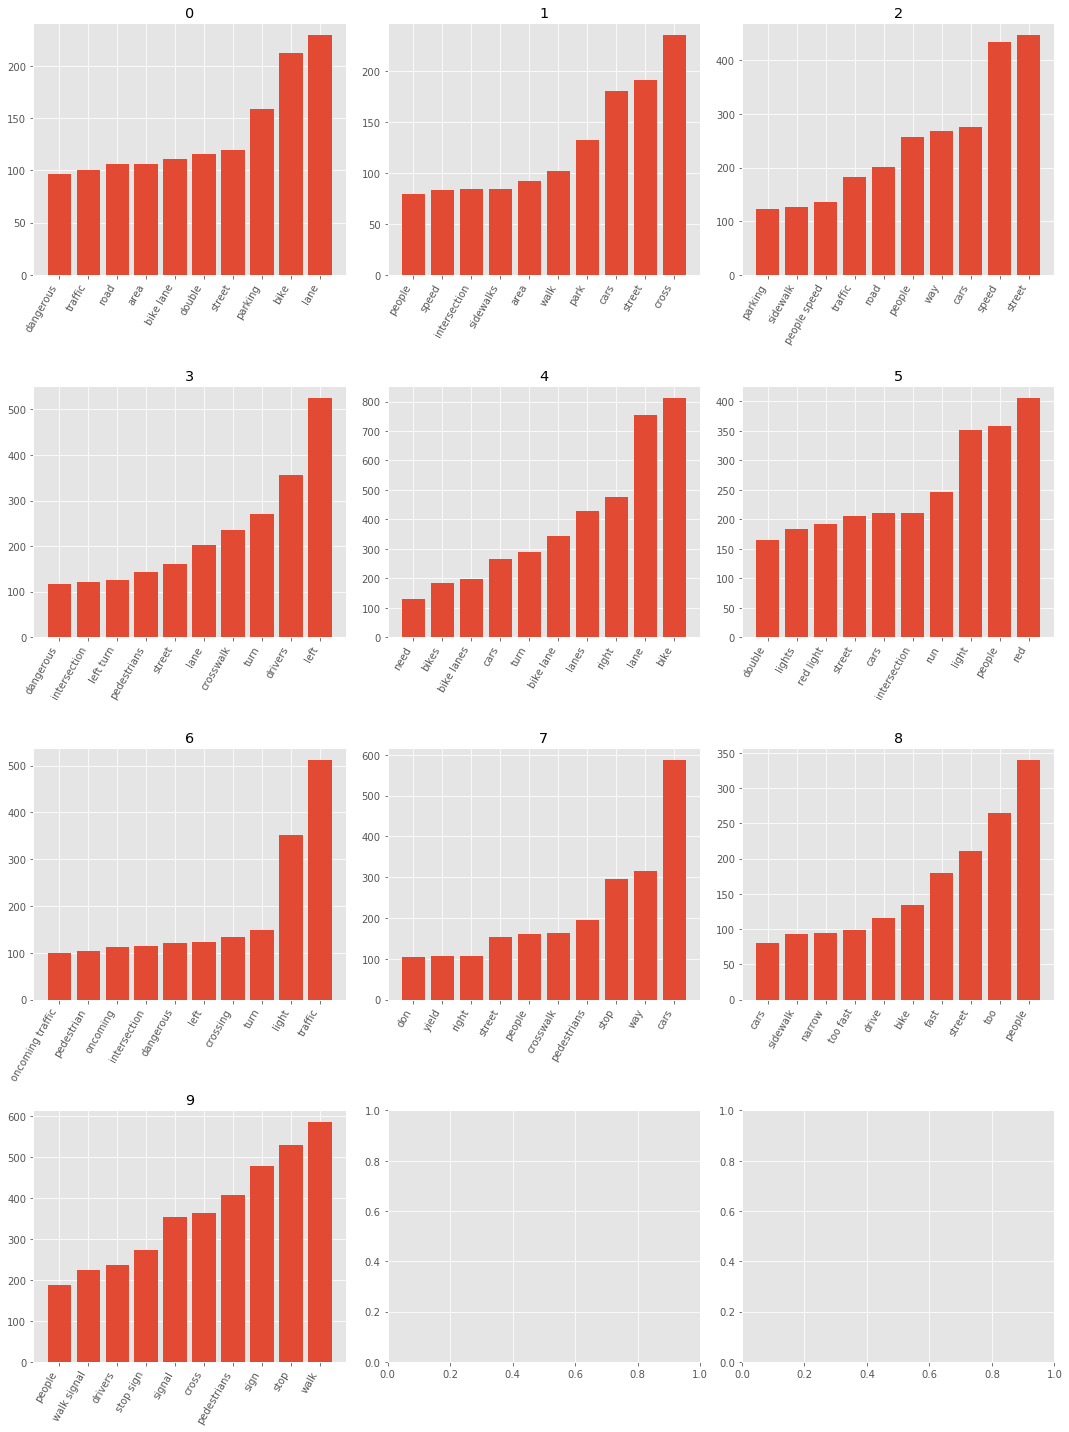

In [72]:
large_comp_inds = np.argsort(X_lda.mean(axis=0))[:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(15, 20))
for i, (ax, coef) in enumerate(zip(axes.ravel(), lda.components_[:, :])):
    plot_important_features_km(coef, feature_names, top_n=10, ax=ax)
    ax.set_title(i)
    
plt.tight_layout()

In [73]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
print_topics(np.argsort(X_lda.sum(axis=0))[::-1][:], feature_names, sorting, topics_per_chunk=5)

topic 4       topic 9       topic 3       topic 2       topic 5       
--------      --------      --------      --------      --------      
bike          walk          left          street        red           
lane          stop          drivers       speed         people        
right         sign          turn          cars          light         
lanes         pedestrians   crosswalk     way           run           
bike lane     cross         lane          people        intersection  
turn          signal        street        road          cars          
cars          stop sign     pedestrians   traffic       street        
bike lanes    drivers       left turn     people speed  red light     
bikes         walk signal   intersection  sidewalk      lights        
need          people        dangerous     parking       double        


topic 7       topic 6       topic 0       topic 1       topic 8       
--------      --------      --------      --------      --------      
cars

In [74]:
y_train_all_lda = X_lda.argmax(axis=1)
X_train_lda, X_val_lda, y_train_lda, y_val_lda = train_test_split(
    X_train_all_bag, y_train_all_lda, stratify=y_train_all_lda, random_state=0)
lr_lda = LogisticRegressionCV().fit(X_train_lda, y_train_lda)
y_val_lda_pred = lr_lda.predict(X_val_lda)
f1_score(y_val_lda, y_val_lda_pred, average='macro')

0.67968984992765713

The LDA model could produce meaningful results, since the topic words are clear and could be easily interpreted. However, there are some overlaps between clusters, such as topic 0 and topic 4. Both of them mentioned bike a lot. As a result, the ARI and f1 score are not very high compared to other models.

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful. The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class. Report accuracy using macro average f1 score (should be above .53)


In [75]:
y_train_all_nmf = X_nmf_scale.argmax(axis=1)
X_train_nmf_final, X_val_nmf_final, y_train_nmf_final, y_val_nmf_final = train_test_split(
    X_train_all, y_train_all_nmf, stratify=y_train_all_nmf, random_state=0)

In [76]:
param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.01],
              "countvectorizer__ngram_range": [(1, 2), (1, 3), (1, 4)],
              "countvectorizer__min_df": [2, 3, 4],
              "countvectorizer__stop_words": [None, my_stopwords],
              "normalizer": [None, Normalizer()]
             }
grid_final = GridSearchCV(make_pipeline(CountVectorizer(token_pattern = r"\b\w[\w’]+\b"), Normalizer(), LogisticRegression()),
                    param_grid=param_grid, cv=5, scoring="f1_macro", verbose = 1)

In [77]:
grid_final.fit(X_train_nmf_final, y_train_nmf_final)
y_val_best_prd_nmf_final = grid_final.best_estimator_.predict(X_val_nmf_final)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int

In [82]:
print(f1_score(y_val_nmf_final, y_val_best_prd_nmf_final, average="macro"))
print(adjusted_rand_score(y_val_nmf_final, y_val_best_prd_nmf_final))
assert f1_score(y_val_nmf_final, y_val_best_prd_nmf_final, average="macro")>0.86

0.875212709531
0.722251702491


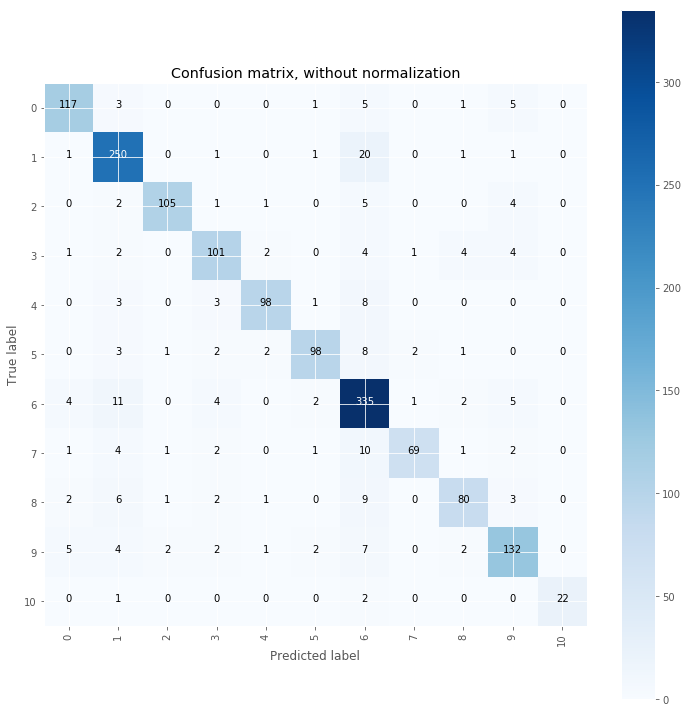

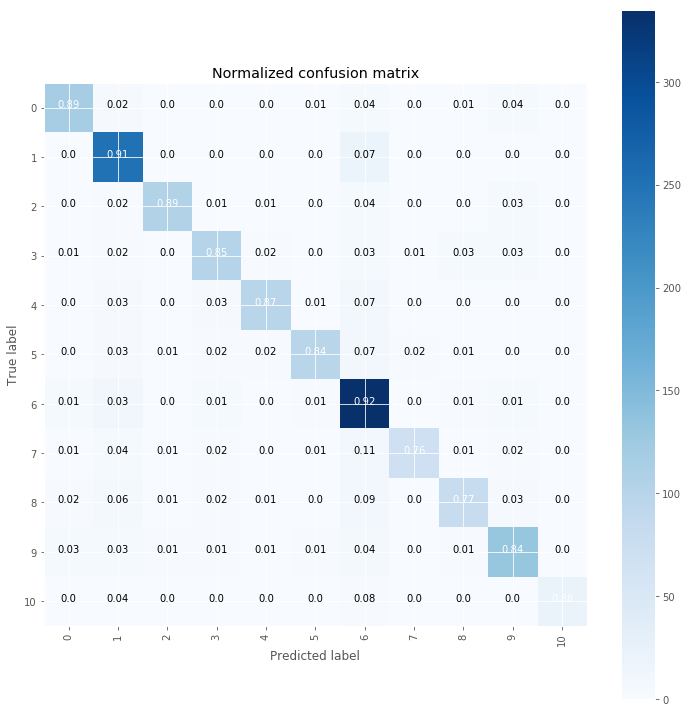

In [79]:
cnf_matrix = confusion_matrix(y_val_nmf_final, y_val_best_prd_nmf_final)
np.set_printoptions(precision=2)

cnf_class = grid_final.best_estimator_.named_steps['logisticregression'].classes_
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=cnf_class,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=cnf_class, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

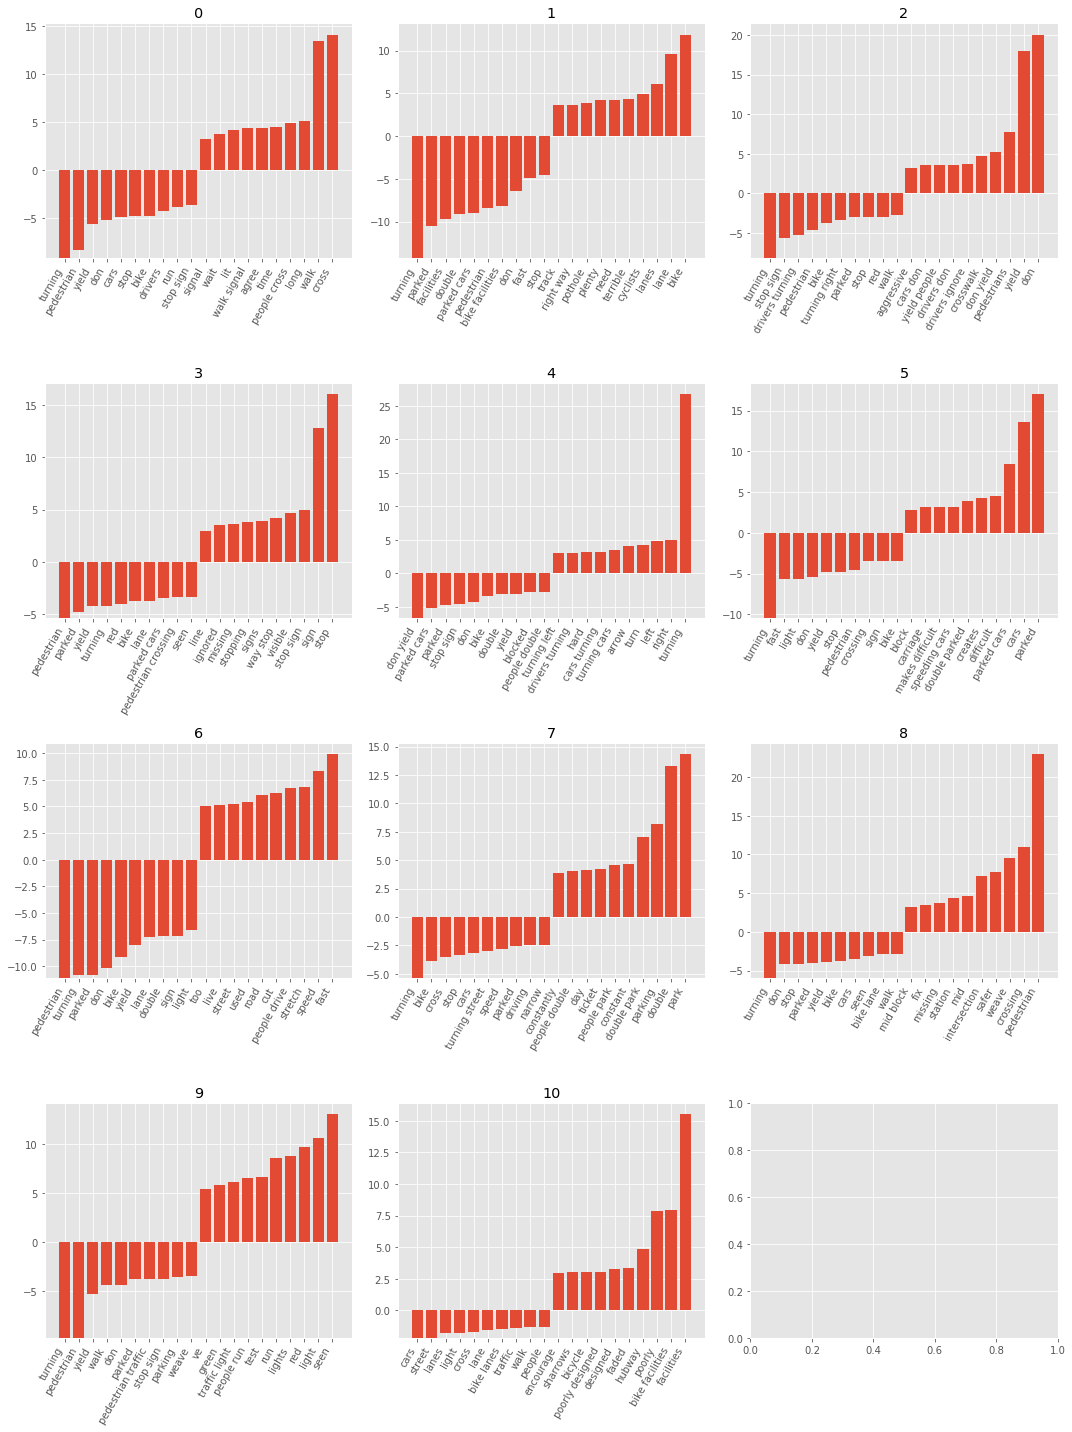

In [80]:
feature_names = np.array(grid_final.best_estimator_.named_steps['countvectorizer'].get_feature_names())
n_classes = len(grid_final.best_estimator_.classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 20))
for ax, coef, label in zip(axes.ravel(), grid_final.best_estimator_.named_steps['logisticregression'].coef_, grid_final.best_estimator_.named_steps['logisticregression'].classes_):
    ax.set_title(label)
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In task6, I use the best clustering model from task5 and run GridSearchCV to find the best hyperparameter. From the results, we could see that the ARI as well as f1 score are very high. The confusion matrix shows that the most of the categories could be predicted correctly, and the 10 clusters is very meaningful. Cluster 0 shows issues about people crossing street, cluster 1 shows bike lines, cluster 2 shows people don't yield, cluster 3 shows people don't follow stop sign, cluster 4 shows turing issues, cluster 5 and 7 shows different parking issues, cluster 6 shows people speed, cluster 8 shows intesection issues, cluster 9 shows light issues,and finally cluster 10 shows bike facilities issues.

# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6.

### Note: We can't upload the GoogleNews-vectors-negative300.bin into Github because the file is too large. We comment the following code in order to run on Travis-CI. However, the results in the output is here and please consider them as answers.

In [13]:
# from gensim import models
# w = models.KeyedVectors.load_word2vec_format(
#     'E:/study/aml/hw4/GoogleNews-vectors-negative300.bin', limit=200000,binary=True)

D:\Anaconda3\lib\site-packages\gensim-2.0.0-py3.5-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
# vect_w2v = CountVectorizer(vocabulary=w.index2word,min_df=3, ngram_range=(1,2), token_pattern=r"\b\w[\w’]+\b")
# vect_w2v.fit(X_train)
# docs = vect_w2v.inverse_transform(vect_w2v.transform(X_train))
# docs[0]

array(['for', 'the', 'be', 'this', 'up', 'one', 'two', 'should', 'way',
       'around', 'stop', 'ways', 'cars', 'speed', 'prevent', 'streets',
       'heading', 'square', 'bike', 'lane', 'blind', 'hill', 'reversed',
       'squeeze', 'curve', 'pedestrians', 'don', 'washington'], 
      dtype='<U98')

In [16]:
# X_train_w2v = np.vstack([np.mean(w[doc], axis=0) for doc in docs])
# lr_w2v = LogisticRegressionCV().fit(X_train_w2v, y_train)
# y_en_pred = lr_w2v.predict(X_train_w2v)
# print(f1_score(y_train, y_en_pred , average="macro"))

0.551814965284


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import Normalizer

# param_grid = {"logisticregression__C": [10, 1, 0.1],
#               "countvectorizer__ngram_range": [(1,2),(1, 4)],
#               "countvectorizer__min_df": [2,3,4],
#               "countvectorizer__stop_words": [None, my_stopwords],
#               "normalizer": [None, Normalizer()]
#              }
# grid = GridSearchCV(make_pipeline(CountVectorizer(vocabulary=w.index2word,token_pattern = r"\b\w[\w’]+\b"), Normalizer(), LogisticRegression()),
#                     param_grid=param_grid, cv=5, scoring="f1_macro", verbose = 1)

In [18]:
# grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the norma

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'countvectorizer__ngram_range': [(1, 2), (1, 4)], 'countvectorizer__stop_words': [None, {'also', 'six', 'thereupon', 'both', 'here', 'himself', 'we', 'part', 'under', 'a', 'somewhere', 'around', 'ourselves', 'serious', 'due', 'him', 'back', 'formerly', 'well', 'sometimes', 'to', 'what', ... 0.1], 'normalizer': [None, Normalizer(copy=True, norm='l2')], 'countvectorizer__min_df': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
     

In [19]:
# y_val_w2v_prd = grid.best_estimator_.predict(X_val)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [20]:
# print(f1_score(y_val, y_val_w2v_prd, average="macro"))

0.5420073196


In the word ensembling process, we used the word2vec method with the model format "GoogleNews-vectors-negative300.bin".
Since the size of the file was too large, we chose the first half of it (out.bin) and limited the size of the first half.
Then we applied it to the model2 tested above. We got macro f1-score 0.54200.